In [52]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from nltk import word_tokenize, sent_tokenize

import keras
from keras.preprocessing.text import Tokenizer #one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, LSTM, SpatialDropout1D, Input, Bidirectional, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
#from keras.regularizers import l2

In [53]:
dtype = {'type': np.int8, 'clear_text': str,}
path = 'C:/Users/user/sentiment/clear_binary_twitts.csv' #home

In [54]:
df = pd.read_csv (path, sep=',', dtype=dtype)

In [55]:
import string
data_lines = []

twitt_data = df['clear_text'].values

lines = twitt_data.tolist()

for line in lines:
    line = str(line)
    data_lines.append(line.split())  #data_lines = [['w1','w2','w3'], ['w4'], ['w5', ..., 'w6'], ...,['wi','wj']]

In [56]:
import gensim

embedding_vector_size = 300
model_1 = gensim.models.Word2Vec(data_lines, size=embedding_vector_size, min_count=1, window=5) #training embeddings for words

words = list(model_1.wv.vocab) #number of unique words
print("vocab size:", len(words))

vocab size: 85754


Text(0,0.5,'frequency')

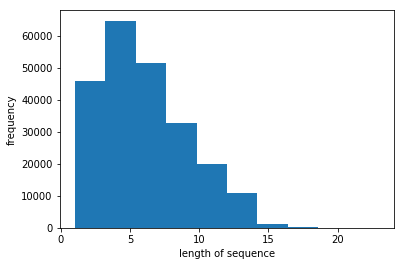

In [57]:
import matplotlib.pyplot as plt
leng=0
length = [(leng + len(x)) for x in data_lines]
plt.hist(length)
plt.xlabel('length of sequence')
plt.ylabel('frequency')

In [58]:
import math
avg_length = sum(length)/len(data_lines)
print(avg_length)

6.0600483172716615


In [59]:
max_len = 12 #how many words in seq to keep. if less than padding with 0

In [60]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)       #keeps 10000 most common words
data = data_lines                       # contains word tokens extracted from lines
tokenizer.fit_on_texts(data)
sequence = tokenizer.texts_to_sequences(data)
data = pad_sequences(sequence, maxlen = max_len)

In [61]:
#__________________________________Preparing embedding matrix______________________________________
vocab_size = len(tokenizer.word_index)+1 # +1 because i starts from 1 instead of 0, and goes till len(vocab)
embedding_matrix = np.zeros((vocab_size, embedding_vector_size))

for  word, i in tokenizer.word_index.items():
    embedding_vector = model_1.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [62]:
X = data
df['label'] = (df['type'] + abs(df['type'])) // 2 # pos 1 --> 1, neg -1 --> 0
y = df['label']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.1, random_state=42, shuffle=True)

In [64]:
model = Sequential()

model.add(Embedding(input_dim = vocab_size, output_dim = embedding_vector_size, 
                    input_length = max_len, weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(64, dropout=0.25, recurrent_dropout=0.1)))
model.add(Dense(10))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [65]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [66]:
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, epochs = 5, batch_size = 700, validation_data=(X_test, y_test),callbacks = [learning_rate_reduction])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 12, 300)           25726500  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               186880    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 25,914,681
Trainable params: 25,914,681
Non-trainable params: 0
_________________________________________________________________
None
Train on 204150 samples, validate on 22684 samples
Epoch 1/5
204150/204150 [==============================] - 248s 1ms/step -

In [67]:
print('val_acc: 0.7156')

val_acc: 0.7156
